In [1]:
import fedhex as fx
from fedhex.pretrain import generation as fxgen
from fedhex.train import Checkpointer, EpochLossHistory, SelectiveProgbarLogger
from matplotlib import pyplot as plt
import numpy as np

Welcome to JupyROOT 6.30/02


2024-02-29 14:01:09.371278: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# List data generation parameters
ndim = 2
sigma = 0.025
ngausx = 5
ngausy = 5
lims = ((0., 1.), (0., 1.))
seed = 0xace1ace1ace1ace1

# Specify generation 'Strategy' for this (gaussian) Generator
# Strategies for gaussian Generators specify the behavior of
# a base covariance matrix that changes over the sample space
strat = fxgen.RepeatStrategy(fxgen.DiagCov(ndim=ndim, sigma=sigma))

In [3]:
# Make a data generator instance for the specified gaussians
ggg = fx.GridGaussGenerator(cov_strat=strat, ngausx=ngausx,
                               ngausy=ngausy, seed=seed, lims=lims)
nsamp = 1000
samples, labels = ggg.generate(nsamp=nsamp)
data, cond = ggg.preproc()

In [4]:
nmade = 10
ninputs = 2
ncinputs = 2
hidden_layers = 1
hidden_units = 128
lr_tuple = (1e-3, 1e-4, 100)
mm = fx.MADEManager(nmade=nmade, ninputs=ninputs, ncinputs=ncinputs,
                    hidden_layers=hidden_layers, hidden_units=hidden_units,
                    activation="relu",
                    lr_tuple=lr_tuple)
mm.compile_model()

In [5]:
starting_epoch = 0
end_epoch = 200
batch_size = 1024
flow_path = "./model/02-29_modelsaveload/"
loss_path = flow_path + "loss.npy"

callbacks = []

save_freq = 50 * batch_size
callbacks.append(Checkpointer(filepath=flow_path, save_freq=save_freq))

callbacks.append(EpochLossHistory(loss_path=loss_path))

log_freq = 10
callbacks.append(SelectiveProgbarLogger(1, epoch_interval=log_freq, epoch_end=end_epoch))

In [6]:
mm.train_model(data=data, cond=cond, batch_size=batch_size,
               starting_epoch=starting_epoch, end_epoch=end_epoch,
               path=flow_path, callbacks=callbacks)

14:01:15.44 <I> [Training begins]
epoch begin: 2024-02-29 14:01:27.837806 | time elapsed: 0:00:12.313345
Epoch 10/200
25/25 [==============================] - 0s 14ms/sample - loss: -1.0643
epoch begin: 2024-02-29 14:01:31.332866 | time elapsed: 0:00:15.808405
Epoch 20/200
25/25 [==============================] - 0s 15ms/sample - loss: -1.5348
epoch begin: 2024-02-29 14:01:34.944110 | time elapsed: 0:00:19.419649
Epoch 30/200
25/25 [==============================] - 0s 15ms/sample - loss: -1.6065
epoch begin: 2024-02-29 14:01:38.555954 | time elapsed: 0:00:23.031493
Epoch 40/200
25/25 [==============================] - 0s 15ms/sample - loss: -1.6332
epoch begin: 2024-02-29 14:01:42.280500 | time elapsed: 0:00:26.756039
Epoch 50/200
25/25 [==============================] - 0s 15ms/sample - loss: -1.6342
epoch begin: 2024-02-29 14:01:46.049041 | time elapsed: 0:00:30.524580
Epoch 60/200
25/25 [==============================] - 1s 22ms/sample - loss: -1.6444
epoch begin: 2024-02-29 14:01:

INFO:tensorflow:Assets written to: ./model/02-29_modelsaveload/assets


14:02:50.01 <I> [Training ends]
0:01:34.57 <I> [Time elapsed]


/home/asatk/miniconda3/envs/rootflows/lib/python3.11/site-packages/keras/src/initializers/__init__.py:144: UserWarning: The `keras.initializers.serialize()` API should only be used for objects of type `keras.initializers.Initializer`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(
/home/asatk/miniconda3/envs/rootflows/lib/python3.11/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'function'>, which may lead to improper serialization.
  warnings.warn(


In [7]:
ngen = 500
gen_labels_unique = [0.5, 0.5]
gen_labels = np.repeat([gen_labels_unique], ngen, axis=0)
gen_cond = ggg.norm(gen_labels, is_cond=True)

gen_data = mm.eval_model(gen_cond)

gen_samples = ggg.denorm(gen_data, is_cond=False)

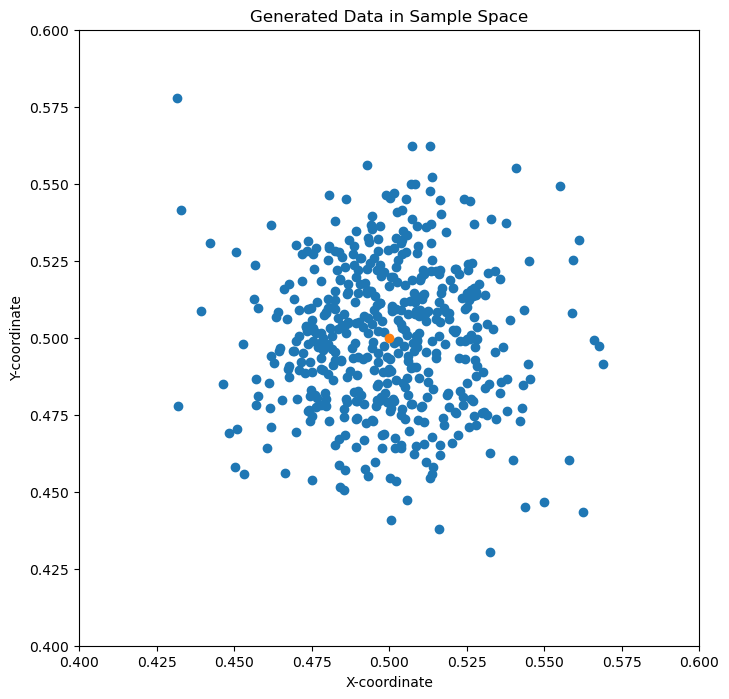

In [8]:
fig, ax1 = plt.subplots(1,1, figsize=(8,8))
ax1: plt.Axes

ax1.scatter(gen_samples[:,0], gen_samples[:,1])
ax1.scatter(gen_labels_unique[0], gen_labels_unique[1])
ax1.set_title("Generated Data in Sample Space")
ax1.set_xlabel("X-coordinate")
ax1.set_ylabel("Y-coordinate")
ax1.set_xlim((0.4, 0.6))
ax1.set_ylim((0.4, 0.6))
pass

In [9]:
mm.save(flow_path + "config.json")

True

In [10]:
# from tensorflow import keras as tfk
# model = tfk.models.load_model(flow_path)

In [11]:
from fedhex.train.tf._MADEflow import load_MADE

model_loaded, dist_loaded, made_list = load_MADE(flow_path=flow_path, newmodel=False)

[<fedhex.train.tf._MADEflow.MADE object at 0x7fb916274290>, <fedhex.train.tf._MADEflow.MADE object at 0x7fb9176a9290>, <fedhex.train.tf._MADEflow.MADE object at 0x7fb916a30490>, <fedhex.train.tf._MADEflow.MADE object at 0x7fb916d41710>, <fedhex.train.tf._MADEflow.MADE object at 0x7fb91c5075d0>, <fedhex.train.tf._MADEflow.MADE object at 0x7fb91726ddd0>, <fedhex.train.tf._MADEflow.MADE object at 0x7fb916ff5d50>, <fedhex.train.tf._MADEflow.MADE object at 0x7fb917646050>, <fedhex.train.tf._MADEflow.MADE object at 0x7fb917524f90>, <fedhex.train.tf._MADEflow.MADE object at 0x7fb9169d2710>]
-----------------------------------------------------
[<tfp.bijectors.MaskedAutoregressiveFlow 'maf_0' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>, <tfp.bijectors.Permute 'permute' batch_shape=[] forward_min_event_ndims=1 inverse_min_event_ndims=1 dtype_x=? dtype_y=?>, <tfp.bijectors.MaskedAutoregressiveFlow 'maf_1' batch_shape=[] forward_min_event_ndims=1 invers

In [12]:
current_kwargs = {}
for i in range(len(made_list) // 2):
    current_kwargs[f"maf_{i}"] = {"conditional_input" : gen_cond}

gen_data_loaded = dist_loaded.sample(len(gen_cond), bijector_kwargs=current_kwargs)
gen_samples_loaded = ggg.denorm(gen_data, is_cond=False)

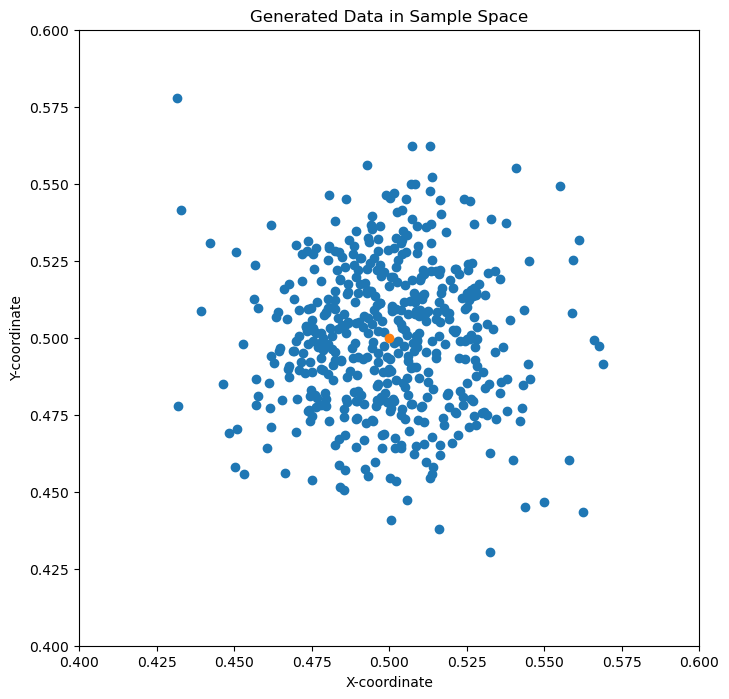

In [13]:
fig, ax1 = plt.subplots(1,1, figsize=(8,8))
ax1: plt.Axes

ax1.scatter(gen_samples_loaded[:,0], gen_samples_loaded[:,1])
ax1.scatter(gen_labels_unique[0], gen_labels_unique[1])
ax1.set_title("Generated Data in Sample Space")
ax1.set_xlabel("X-coordinate")
ax1.set_ylabel("Y-coordinate")
ax1.set_xlim((0.4, 0.6))
ax1.set_ylim((0.4, 0.6))
pass

In [14]:
hist, xedges, yedges = np.histogram2d(gen_samples[:,0], gen_samples[:,1], range=((0.4,0.6),(0.4,0.6)))
hist_load, xedges, yedges = np.histogram2d(gen_samples_loaded[:,0], gen_samples_loaded[:,1], range=((0.4,0.6),(0.4,0.6)))

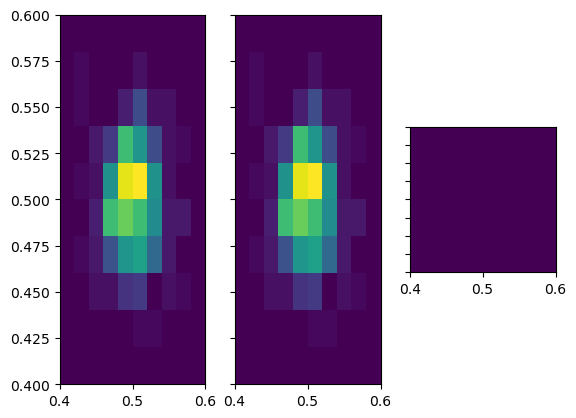

In [17]:
from matplotlib import pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)
h1, _, _, _ = ax1.hist2d(gen_samples[:,0], gen_samples[:,1], range=((0.4,0.6),(0.4,0.6)))
h2, _, _, _ = ax2.hist2d(gen_samples_loaded[:,0], gen_samples_loaded[:,1], range=((0.4,0.6),(0.4,0.6)))
h3 = h1-h2
ax3.imshow(h3)
plt.show()